# Testat

In [16]:
import os
import skimage
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import io
from skimage import util
from skimage.filters import threshold_otsu
from skimage.transform import hough_line, hough_line_peaks
from tensorflow.keras.models import load_model
from numpy import argmax

### 1. Load Image, resize and convert

In [3]:
directory = "examples"
files = os.listdir(directory)

imgs = []
for file in files:
    img = io.imread(os.path.join(directory, file), as_gray=True)
    img = skimage.exposure.adjust_gamma(img, 2)
    imgs.append(img)


### 2. Canny edge detector

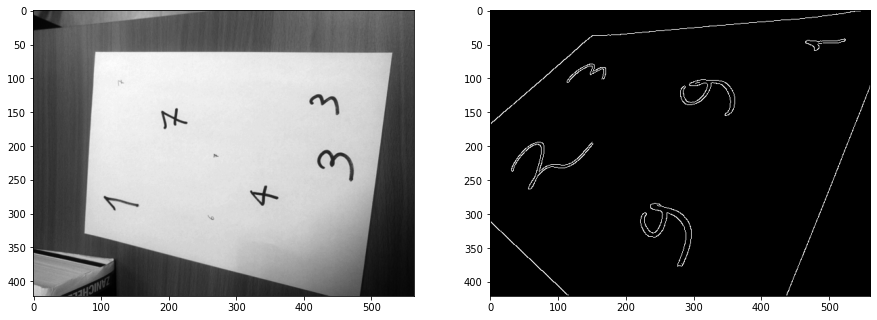

In [4]:
sigma = 0.5
low = 0.3
high = 0.7

imgs_edges = []
for img in imgs:
    imgs_edges.append(skimage.feature.canny(img, sigma=sigma, low_threshold=low, high_threshold=high))

im_edges = imgs_edges[0]
fig, axs = plt.subplots(ncols=2, figsize=(15,10))
axs[0].imshow(img, cmap="gray")
axs[1].imshow(im_edges, cmap="gray")

### 3. Hough line detector

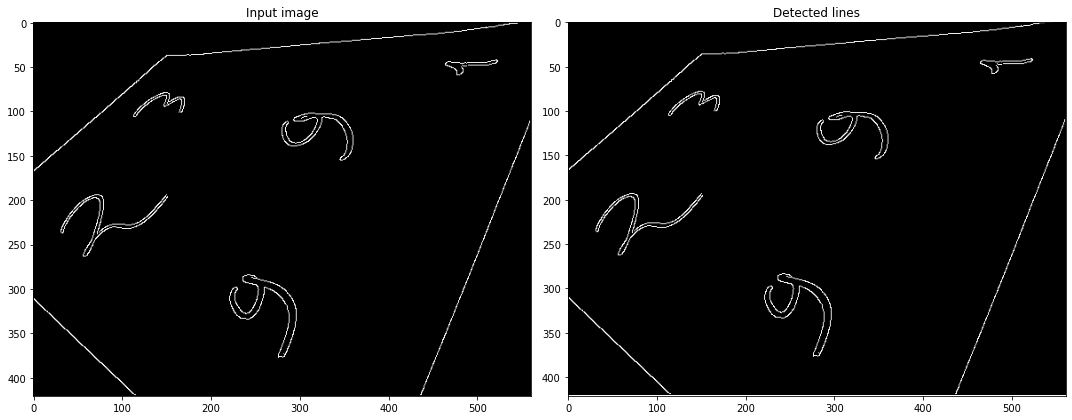

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
plot = True
for img in imgs_edges:
    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        ax = axes.ravel()

        ax[0].imshow(img, cmap="gray")
        ax[0].set_title('Input image')
        ax[1].imshow(img, cmap="gray")
        ax[1].set_ylim((img.shape[0], 0))
        ax[1].set_title('Detected lines')


    xs = []
    ys = []
    slopes = []
    bs = []
    colors = ["r", "g", "b", "y"]

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        i = len(xs)
        xs.append(x0)
        ys.append(y0)
        slope = np.tan(angle + np.pi/2)
        slopes.append(slope)
        bs.append(y0 - slope * x0)
        #if plot:
        #    ax[1].axline((x0, y0), slope=slope, color=colors[i])
            
    plt.tight_layout()
    plt.show()
    plot = False

### 4. Find intersections

In [6]:
def line_intersect(m1, b1, m2, b2):
    x = int((b2 - b1) / (m1 - m2))
    y = int(m1 * x + b1)
    return x, y

[(531, 64), (482, 434), (91, 61), (75, 337)]


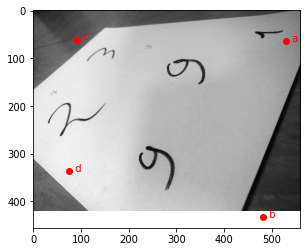

In [7]:
plot = True
for img in imgs:
    points = []

    pairs = [(1,2), (1,3), (1,4), (2,3), (2,4), (3,4)] # all possible intersecions

    for pair in pairs:
        i = pair[0] - 1
        k = pair[1] - 1
        xt, yt = line_intersect(slopes[i], bs[i], slopes[k], bs[k])
        # ignore intersections that are far away, probably intersection between top+bottom or left+right
        if xt < 1.2 * img.shape[1] and yt < 1.2 * img.shape[0] and xt > 0 and yt > 0:
            points.append((xt, yt))
    if plot:
        plt.imshow(img, cmap="gray")

        labels = ["  a", "  b", "  c", "  d"]
        for i in range(len(xs)):
            plt.scatter(points[i][0], points[i][1], marker='o', color='r')
            plt.text(points[i][0], points[i][1], labels[i], color='r')
            #plt.axline((xs[i], ys[i]), slope=slopes[i], color=colors[i])
        print(points)
    plot = False

### 5. Geometric transformation

In [8]:
# get long / short lines
def get_dist(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

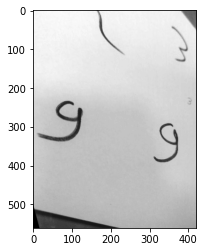

In [9]:
tims = []

for img in imgs:

    tl = (0, 0)
    tr = (img.shape[1], 0)
    br = (img.shape[1], img.shape[0])
    bl = (0, img.shape[0])

    corner_dict = {
        "top_left": tl,
        "top_right": tr,
        "bottom_right": br,
        "bottom_left": bl
    }

    for k, v in corner_dict.items():
        distances = []
        for point in points:
            distances.append(get_dist(v, point))
            corner_dict[k] = points[np.argmin(distances)]
    top_dist = get_dist(corner_dict["top_left"], corner_dict["top_right"])
    left_dist = get_dist(corner_dict["top_left"], corner_dict["bottom_left"])
    right_dist = get_dist(corner_dict["top_right"], corner_dict["bottom_right"])
    bottom_dist = get_dist(corner_dict["bottom_left"], corner_dict["bottom_right"])

    if top_dist < left_dist:
        # paper is in correct orientation
        w,h = img.shape[1], img.shape[0] # keep original w and h
        invtf = skimage.transform.estimate_transform("projective", 
                                                     src=np.vstack((tl,tr,bl,br)), 
                                                     dst=np.vstack((corner_dict["top_left"], 
                                                                    corner_dict["top_right"], 
                                                                    corner_dict["bottom_left"], 
                                                                    corner_dict["bottom_right"] )))
    else:
        # paper is not in correct orientation, rotate
        a = np.array(corner_dict["top_left"])
        b = np.array(corner_dict["top_right"])
        c = np.array(corner_dict["bottom_right"])
        d = np.array(corner_dict["bottom_left"])

        w,h = img.shape[0], img.shape[1] # switch w and h of original img

        A = np.array([w, 0]) # top right
        B = np.array([w, h]) # bottom right
        C = np.array([0, h]) # bottom left
        D = np.array([0, 0]) # top left
        invtf = skimage.transform.estimate_transform("projective",
                                                     src=np.vstack((A,B,C,D)),
                                                     dst=np.vstack((a,b,c,d))
                                                    )
        tim = skimage.transform.warp(image=img, inverse_map=invtf, output_shape=(h, w))
        tims.append(tim)

plt.imshow(tims[0], cmap="gray")

### 6. Binarize and find connected components

Unique values in labels: [0 1 2 3 4 5 6 7 8 9]


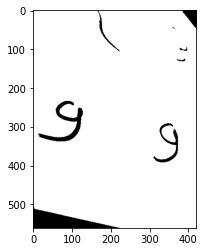

In [10]:
labels = []
binaries = []
for tim in tims:
    thresh = threshold_otsu(tim)
    binary = tim > thresh
    label = skimage.measure.label(binary, background=1)
    labels.append(label)
    binaries.append(binary)

print("Unique values in labels:", np.unique(labels[0]))
plt.imshow(binaries[0], cmap="gray")

### 7. Draw bounding boxes and crop nrs

In [11]:
large_regions = []
min_size = w / 10 
max_size = w + h * 2
for label in labels:
    regions = skimage.measure.regionprops(label)
    large_region = [r for r in regions if r.area > min_size and r.area < max_size]
    large_regions.append(large_region)

print(f"There are {len(large_regions[0])} large regions in the first image")

There are 5 large regions in the first image


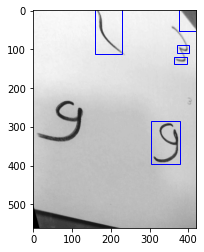

In [12]:
nrs = {}
plot = True
for i in range(len(tims)):
    nrs[i] = []
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(tims[i], cmap="gray")
    for r in large_regions[i]:
        (min_row, min_col, max_row, max_col) = r.bbox
        width = (max_col+10) - min_col
        height = (max_row+10) - min_row
        rect = patches.Rectangle((min_col-5,min_row-5),width,height,
                                 linewidth=1,edgecolor='b',facecolor='none')
        if width > 25 and height > 25:
          nrs[i].append(tims[i][min_row-5:max_row+5, min_col-5:max_col+5])
        if plot:
            ax.add_patch(rect)
    plot = False

#### Preprocessing and Classification

In [17]:
results = {}
nrs_preprocessed = {}
values = {}
preds = {}

for i in range(len(tims)):
    results[i] = []
    nrs_preprocessed[i] = []
    values[i] = []
    preds[i] = []

    for nr in nrs[i]:
        if nr.shape > (25,25):
          # switch background and foreground for mnist
          nr = util.invert(nr) 
          # resize image to mach input dim (1,28,28)
          nr = skimage.transform.resize(nr, (28, 28), anti_aliasing=False)
          nrs_preprocessed[i].append(nr)
          nr = nr.reshape(1, 28, 28, 1)
          nr = nr.astype('float32')

          # get prediction
          model = load_model('final_model.h5')
          # predict class
          predict_value = model.predict(nr)
          digit = argmax(predict_value)

          results[i].append(digit)


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 59ms/step


In [21]:
def show_images(images: list, labels: list, rows: int = 5) -> None:
    """
    Display a list of images in a single figure
    
    :param images: List of np.arrays compatible with plt.imshow.    
    :param rows: Number of rows in figure
    :return: None
    """
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(int(np.ceil(n_images/float(rows))), rows, n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.title(f"Predicted digit: {labels[n]}", fontsize=40)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [22]:
images = []
labels = []
for i in range(len(nrs_preprocessed)):
  l = len(nrs_preprocessed[i])
  for j in range(l):
      images.append(nrs_preprocessed[i][j])
      labels.append(results[i][j])

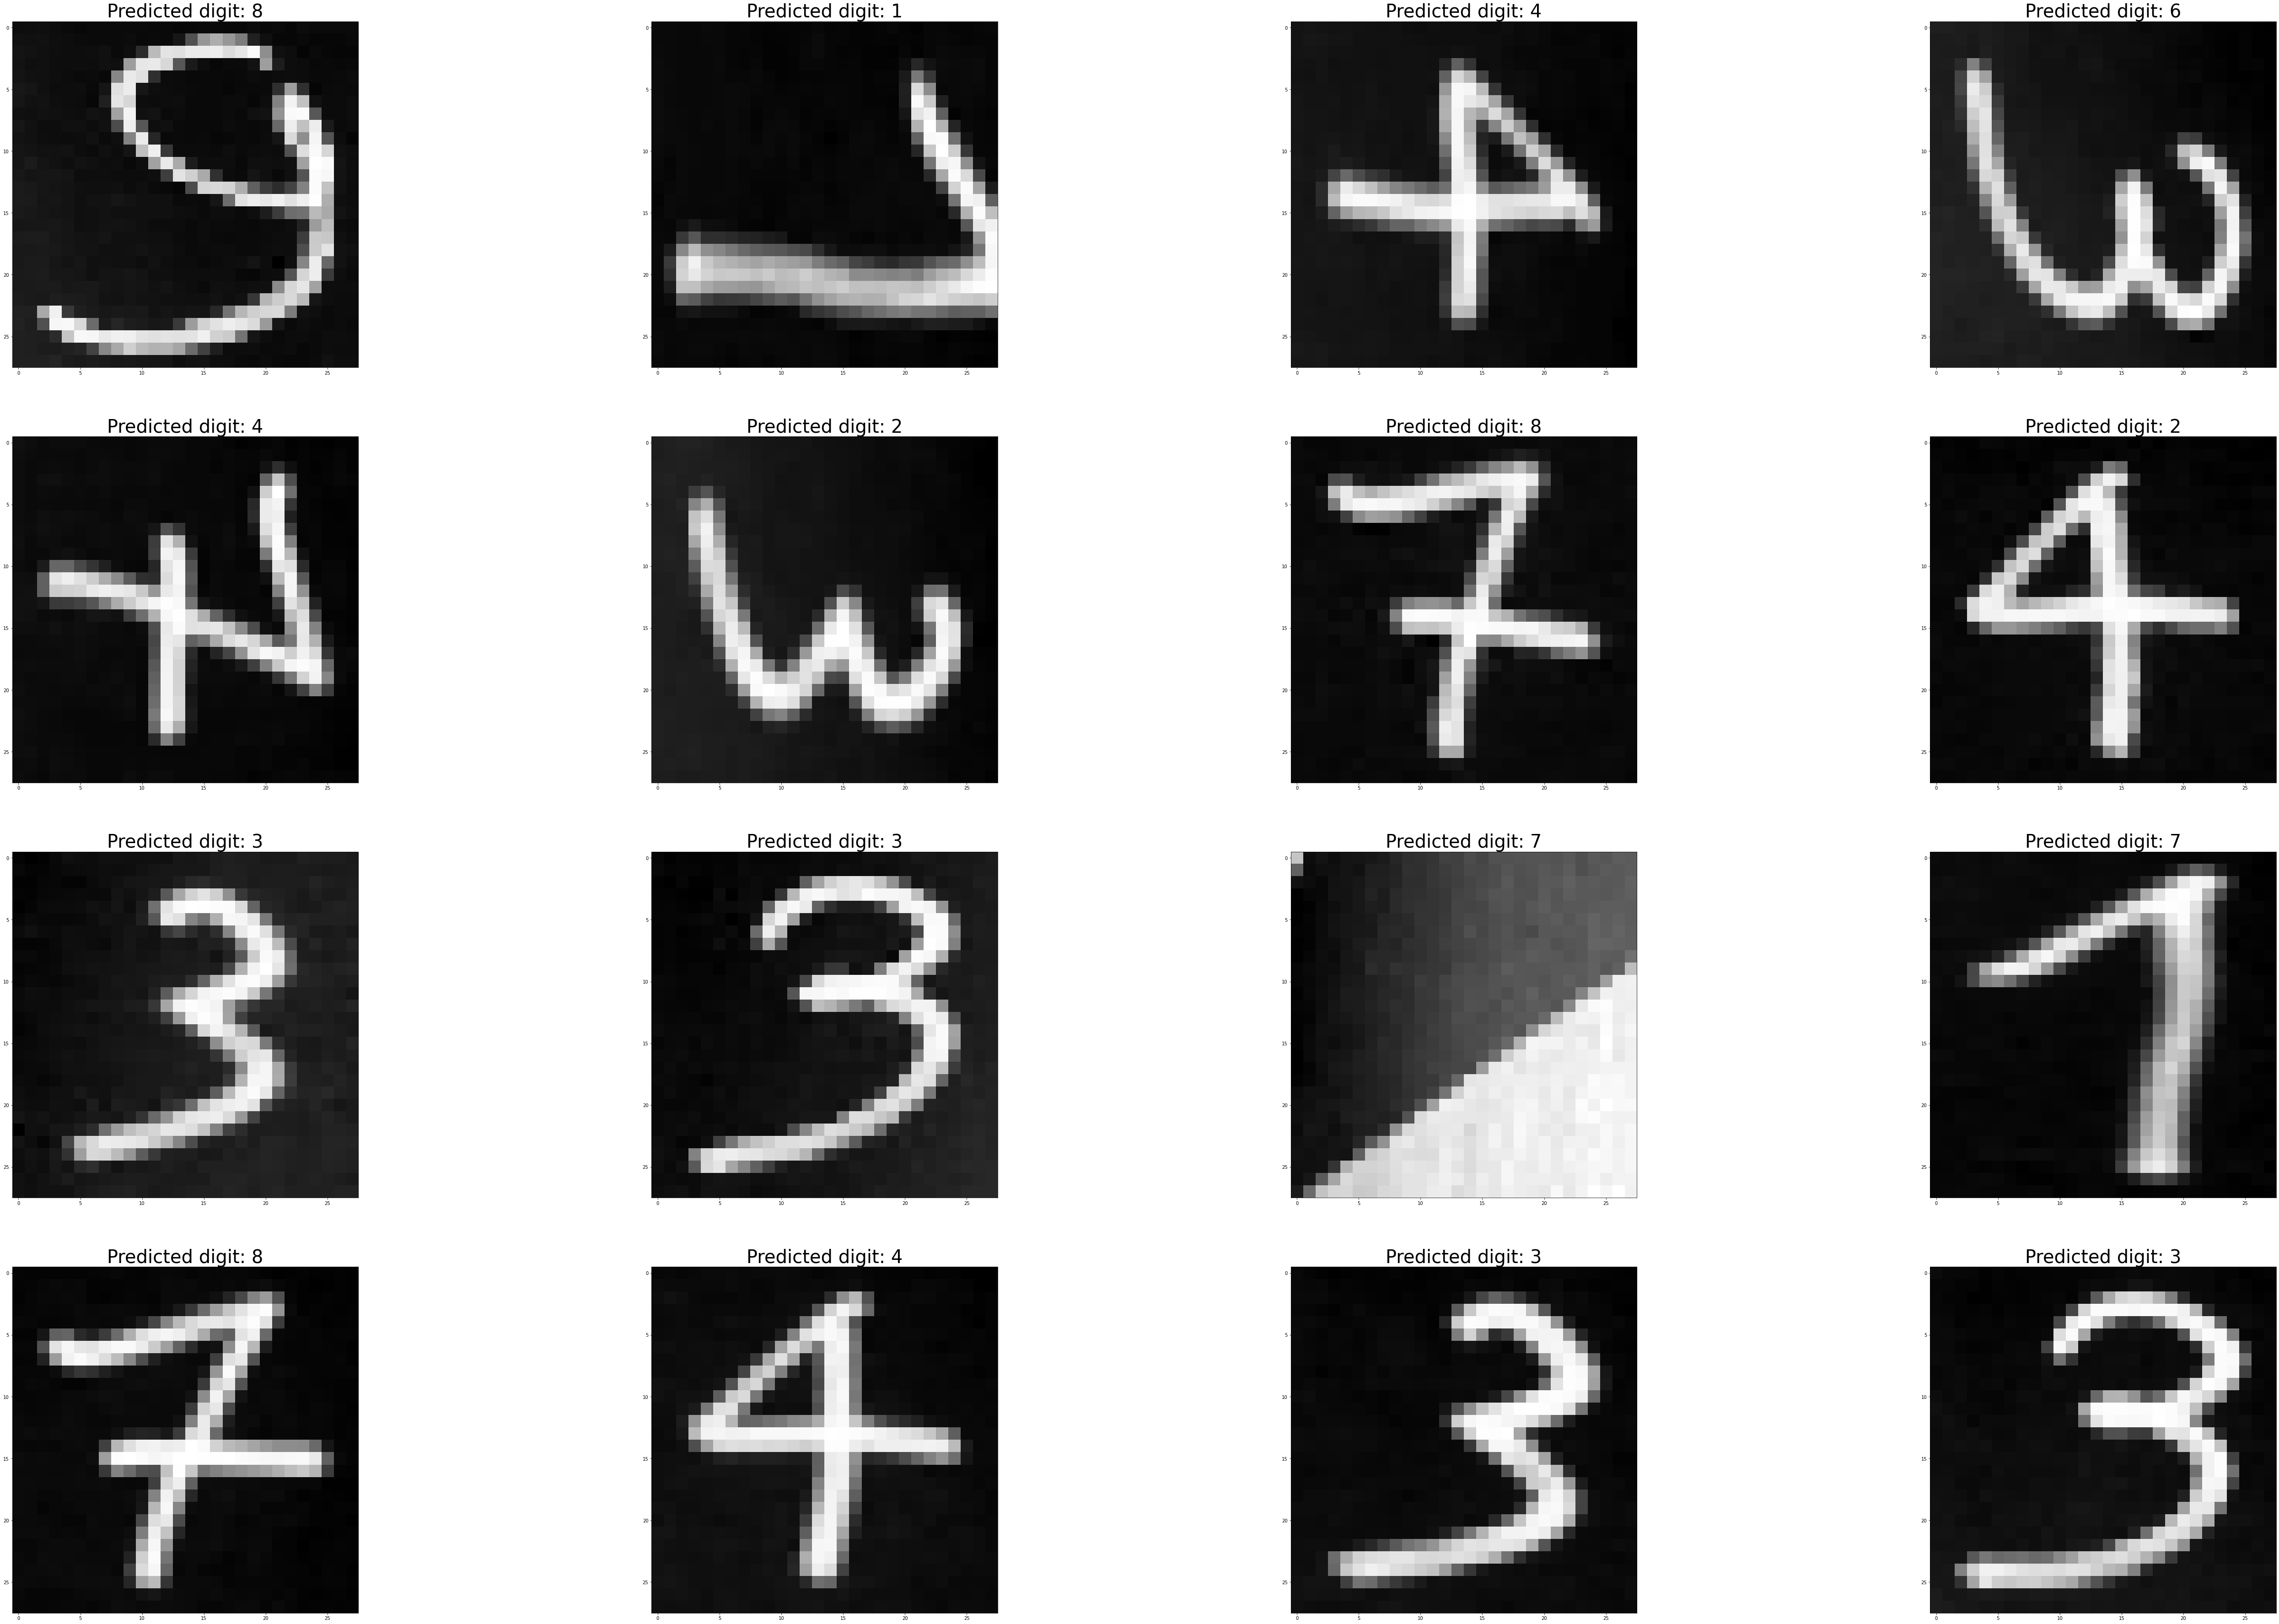

In [23]:
show_images(images, labels=labels, rows=4)